# Quantum Search on an hypercube

In this notebook, we will program a simple Quantum Walk that seaches for marked elements in an hypercube.
The implementation will be done using `myqlm` which is a collection of tools to program and execute quantum programs. The python library provided by `myqlm` is called `qat`.


An hypercube of dimension $n$ is graph $G=(V, E)$ defined as follows: vertices are bitstrings of fixed length $n$ and two bitstrings are neighbors if and only if they only differ in a single position.

More formally:
 - $V = \{0, 1\}^n$
 - $\forall x, y \in V, \{x, y\} \in E \Leftrightarrow |x\oplus y| = 1$
 
 
## The ingredients

Recall the structure of a Quantum Walk based search that looks for elements in a subset $M\subseteq X$ marked by some oracle $f$. 

**Memory**: We will need a quantum state that represents edges of our graphs (that is, pairs of vertices). In our case this means that we will need two quantum registers of length $n$, each storing one extremity of an edge, like so: $|x\rangle |y\rangle $.

We note $|p_x\rangle = \frac{1}{\sqrt{d(x)}} \sum_{y\in \mathcal{N}_x} |y\rangle$, that is the uniform superposition of neighbors of vertex $x$ in $G$.

**Pseudo-code**: The search goes as follow:

1) prepare the memory in the state $|U\rangle = \frac{1}{\sqrt{|X|}}\sum_x |x\rangle|p_x\rangle$

2) Repeat enough time the following amplification:
* reflect through $|B\rangle = \frac{1}{\sqrt{|X| - |M|}}\sum_{x, P(x)=0} |x\rangle|p_x\rangle$
* reflect through the uniform distribution $|U\rangle = \frac{1}{\sqrt{|X|}}\sum_{x} |x\rangle|p_x\rangle$



For this we will need the following subroutines:

- a subroutine called $U$ that, given some vertex, prepares a superposition of its neighbors in $G$:
$$ U:|x\rangle|0\rangle \mapsto |x\rangle|p_x\rangle $$

- a subroutine implementing $U_f$

- an implementation of the $W(G)$ unitary operator (see details below)

- a Quantum Phase Estimation of $W(G)$


## Implementing $U$ for an hypergraph

In order to implement $U$, we need to program a quantum circuit that takes a bitstring in a register and creates a uniform superposition of all the bitstrings obtained by flipping a single bit of this bitstrings.

The following piece of code is a single routine that takes a register in state $|0\rangle$ and creates a uniform superposition of bitstring of Hamming weight $1$ (i.e bitstrings obtained by take the all zero bitstring and flipping a single bit).

It does so by successively splitting $|0...0\rangle$ into $|0...0\rangle$ and $|h_i\rangle$ where $h_i$ is a bitstring of Hamming weight $1$.

In [1]:
# This imports all we need to build quantum circuits
from qat.lang.AQASM import *
import numpy as np


def superposition_bit_flips(bitlength):
    # This method builds an object call a QRoutine which corresponds 
    # to a subcircuit we will reuse many times
    routine = QRoutine()
    # wires of the subcircuit are allocated using .new_wires(N)
    reg = routine.new_wires(bitlength)

    ctrls = []
    
    for i in range(bitlength):
        # This is the angle needed for the ith RY rotation (trust me on this one)
        angle = 2 * np.arcsin(1 / np.sqrt(bitlength - i))
        # we perform a controled RY gate in order to split |0...> onto |0..> + |h_i>
        # These lines flip all the qubits from 0 to i-1
        with routine.compute():
            for w in ctrls:
                X(w)
        # These lines perform the controled RY gates (or a simple RY if at the start)
        if ctrls:
            RY(angle).ctrl(len(ctrls))(ctrls, reg[i])
        else:
            RY(angle)(reg[i])
        # This line undoes the bit flip from above
        routine.uncompute()
        ctrls.append(reg[i])
    return routine

# testing

superposition_3 = superposition_bit_flips(3)
%qatdisplay superposition_3 --svg

# simulating it, just to be sure
# this imports the default simulator (a numpy based simulator)
from qat.qpus import get_default_qpu
qpu = get_default_qpu()

prog = Program()
qbits = prog.qalloc(3)
# applying the routine on 3 qubits
superposition_3(qbits)
circuit = prog.to_circ()

result = qpu.submit(circuit.to_job())
for sample in result:
    print(sample.state, sample.probability)

|001> 0.3333333333333333
|010> 0.33333333333333315
|100> 0.3333333333333334


So now we can create a superposition of $n$ bit flips.
In order to implement $U: |x\rangle |0\rangle \mapsto |x\rangle |p_x\rangle$
we can simply:
- call our `superposition_bit_flips`:
$$ |x\rangle |0\rangle \mapsto |x\rangle \sum_i |h_i\rangle  $$
- XOR the first register into the second (since for all $i$, $h_i \oplus x$ is a neighbor of $x$ in $G$)

We will call this new routine `query_neighbors` because that's what it does :)

In [2]:

def query_neighbors(bitlength):
    routine = QRoutine()
    reg_x = routine.new_wires(bitlength)
    reg_neighbors = routine.new_wires(bitlength)
    # calling the superposition
    superposition_bit_flips(bitlength) (reg_neighbors)
    # XORING using CNOT gates
    for a, b in zip(reg_x, reg_neighbors):
        CNOT(a, b)
    return routine

# testing
neighs_3 = query_neighbors(3)
%qatdisplay neighs_3 --svg

prog = Program()
reg_x = prog.qalloc(3)
reg_n = prog.qalloc(3)
# Setting the register to |101>
# We should get |101>|100> + |101>|111> + |101>|001>
X(reg_x[0])
X(reg_x[2])
neighs_3(reg_x, reg_n)
circuit = prog.to_circ()

result = qpu.submit(circuit.to_job())
for sample in result:
    print(sample.state, sample.probability)

|101>|001> 0.3333333333333334
|101>|100> 0.3333333333333333
|101>|111> 0.33333333333333315


## Implementing $W(G)$

$W(G)$ is defined as follows:
- perform a reflection through subspace $span\{|x\rangle|p_x\rangle\}$

- perform a reflection through subspace $span\{|p_y\rangle|y\rangle\}$

Let's have a look at the first reflection. It can be implemented as follows:

- apply the inverse of $$ |x\rangle|0\rangle \mapsto |x\rangle|p_x\rangle $$
- inverse the phase of $$ |x\rangle|0\rangle$$
- apply $$ |x\rangle|0\rangle \mapsto |x\rangle|p_x\rangle $$

In other words:
- the first step ensures that elements of the subspace of interest $\{|x\rangle|p_x\rangle\}$ ends up having their second register in state $|0\rangle$
- the second step inverts the phase of states having $|0\rangle$ in their second register (that is elements of the subspace of interest)
- the last steps simply undoes the first step

The second reflection is simply the same thing, except that we will invert the two registers.

In [3]:
def reflection(bitlength):
    routine = QRoutine()
    reg_x = routine.new_wires(bitlength)
    reg_n = routine.new_wires(bitlength)
    
    with routine.compute():
        query_neighbors(bitlength).dag()(reg_x, reg_n)
    
    # flipping the phase iff the second register is set to 0
    with routine.compute():
        for qbit in reg_n:
            X(qbit)
    Z.ctrl(bitlength - 1)(reg_n)
    routine.uncompute()
    routine.uncompute()
    return routine

# test
ref_3 = reflection(3)
%qatdisplay ref_3 --svg

@build_gate("WG", [int], arity=lambda n: 2 * n)
def wg(bitlength):
    routine = QRoutine()
    reg_x = routine.new_wires(bitlength)
    reg_n = routine.new_wires(bitlength)
    refl = reflection(bitlength)
    refl(reg_x, reg_n)
    refl(reg_n, reg_x)
    return routine

wg_3 = wg(3)
%qatdisplay wg_3 --svg --depth 1

## Implementing a Quantum Phase Estimation for $W(G)$

This step is rather simple, we just need to apply the standard construction of a QPE on $W(G)$.


In [4]:
from qat.lang.AQASM.qftarith import QFT

def qpe_wg(bitlength, qpe_bits):
    routine = QRoutine()
    reg_data = routine.new_wires(2 * bitlength)
    reg_phase = routine.new_wires(qpe_bits)
    wg_routine = wg(bitlength)
    for qbit in reg_phase:
        H(qbit)
    for index, qbit in enumerate(reg_phase):
        for index in range(1 << index):
            wg_routine.ctrl()(qbit, reg_data)
    QFT(qpe_bits).dag()(reg_phase)
    return routine


qpe_3 = qpe_wg(3, 3)

%qatdisplay qpe_3 --svg

# Implementing the reflection through the uniform distribution

Recall that we can implement the reflection by:
- using a QPE to estimate the phase of the state
- inverting the phase of state whose phase is $0$
- udoing the QPE


In [5]:
def reflection_uniform(bitlength, qpe_bits):
    routine = QRoutine()
    data_reg = routine.new_wires(2 * bitlength)
    phase_reg = routine.new_wires(qpe_bits)
    routine.set_ancillae(phase_reg)
    # Estimating the phase
    with routine.compute():
        qpe_wg(bitlength, qpe_bits)(data_reg, phase_reg)
        for qbit in phase_reg:
            X(qbit)
    # Inverting the phase iff the estimated phase is 0
    Z.ctrl(qpe_bits - 1)(phase_reg)
    # undoing the QPE
    routine.uncompute()
    return routine
rout = reflection_uniform(3, 3)
%qatdisplay rout --svg

## The Oracle for $P$

The last thing we need is an oracle that marks a subset of the bitstrings.
I propose here an implementation of an oracle that checks if a bitstring is a palindrome. It's stupid, but more interesting that marking a single state.

We will directly implement the reflection: $$|x\rangle \mapsto (-1)^{P(x)} |x\rangle $$
since that's what we need.

In [6]:
def check_palindrome(bitlength):
    routine = QRoutine()
    reg = routine.new_wires(bitlength)
    first_half = reg[:bitlength // 2]
    last_half = reg[bitlength - bitlength // 2:][::-1]
    with routine.compute():
        for a, b in zip(first_half, last_half):
            CNOT(a, b)
        for qb in last_half:
            X(qb)
    
    Z.ctrl(bitlength // 2 - 1)(last_half)
    routine.uncompute()
    return routine
# test
cp_5 = check_palindrome(20)
%qatdisplay cp_5 --svg

In [7]:
# The Quantum Walk!

def quantum_walk_step(bitlength, qpe_bits):
    routine = QRoutine()
    reg1 = routine.new_wires(bitlength)
    reg2 = routine.new_wires(bitlength)
    
    check_palindrome(bitlength)(reg1)
    reflection_uniform(bitlength, qpe_bits)(reg1, reg2)
    
    return routine

def quantum_walk_search(bitlength, qpe_bits, nsteps):
    prog = Program()
    reg1 = prog.qalloc(bitlength)
    reg2 = prog.qalloc(bitlength)
    
    # preparing |U>
    for qbit in reg1:
        H(qbit)
    query_neighbors(bitlength)(reg1, reg2)
    
    step = quantum_walk_step(bitlength, qpe_bits)
    for _ in range(nsteps):
        step(reg1, reg2)
    return prog.to_circ().to_job(qubits=[reg1])

        

In [8]:
n = 5
qpe_bits = 2
data = []
N = 1 << n
K = 8
p = np.pi / 4 / np.arcsin(np.sqrt(K/N))
print(p)
for nsteps in range(1, 16):
    job = quantum_walk_search(n, qpe_bits, nsteps)
    result = qpu.submit(job)
    success_prob = 0
    for sample in result:
        if sample.state.value[0] == sample.state.value[0][::-1]:
            success_prob += sample.probability
    data.append([nsteps, success_prob])
    print(nsteps, success_prob)

1.4999999999999998
1 0.9288320460799947
2 0.351076016381884
3 0.3856231695776216
4 0.5836941991483499
5 0.5812084821215214
6 0.38259564876083724
7 0.3842328239680406
8 0.9077360982904503
9 0.2008880464209564
10 0.3088325715005053
11 0.9414745952401964
12 0.3109740424186618
13 0.39027250741992386
14 0.5917817813696199
15 0.5821649567286798


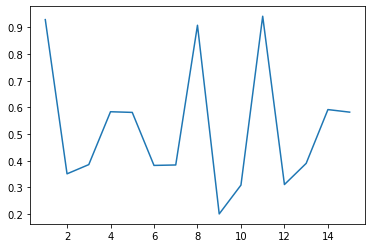

In [9]:
import matplotlib.pyplot as plt
data = np.array(data)
plt.plot(data[:, 0], data[:, 1])
plt.show()